In [5]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

In [6]:
# ==========================================
# Simulator setup
# ==========================================
S0 = 100.0      # Current stock price
K = 99.0        # Strike price
r = 0.06        # Risk-free interest rate 6%
T = 1.0         # Maturity 1 year
N_PATHS = 10000 # Number of Monte Carlo simulation paths (using vectorization to run 10,000 parallel paths at once)

def bs_call_price_delta(S, K, tau, r, sigma):
    """
    Calculate Black-Scholes call option price and Delta
    tau: Time to maturity (T - t)
    """
    # Avoid division by zero error at maturity t=T when tau=0
    tau = np.maximum(tau, 1e-10) 
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))
    d2 = d1 - sigma * np.sqrt(tau)
    
    price = S * norm.cdf(d1) - K * np.exp(-r * tau) * norm.cdf(d2)
    delta = norm.cdf(d1)
    
    return price, delta

def run_hedging_simulation(steps, sigma_path, sigma_model):
    """
    Execute Euler method hedging simulation 
    steps: Number of hedging steps (e.g., daily steps=252, weekly steps=52)
    sigma_path: Volatility for generating the true stock price path
    sigma_model: Volatility used to calculate the BS Delta
    """
    dt = T / steps
    
    # Initialize stock price array, all 10,000 paths start at S0
    S = np.full(N_PATHS, S0)
    
    # --- t=0 Initial position setup ---
    # We short the option (receive option premium C0) and set up the replicating hedge portfolio V
    C0, current_delta = bs_call_price_delta(S, K, T, r, sigma_model)
    
    # Initial total value of the portfolio equals the premium received from selling the option
    V = np.copy(C0) 
    # We immediately buy current_delta shares of stock, and put the remaining cash into bank account B to earn interest
    B = V - current_delta * S 
    
    # --- Start time step iteration (Euler method simulation) ---
    for i in range(1, steps + 1):
        t = i * dt
        tau = T - t # Remaining time to maturity
        
        # 1. Euler step: Generate new stock prices 
        Z = np.random.standard_normal(N_PATHS)
        S = S + r * S * dt + sigma_path * S * np.sqrt(dt) * Z
        
        # 2. Portfolio value update: Bank account accrues interest, stock prices change
        B = B * np.exp(r * dt) # Continuous compounding
        V = current_delta * S + B # Current total value of the hedge portfolio
        
        # 3. Dynamic rebalancing: If it's not the last day, we need to calculate the new Delta
        if i < steps:
            _, new_delta = bs_call_price_delta(S, K, tau, r, sigma_model)
            # Self-financing constraint: Adjust stock position, the price difference is absorbed by the bank account
            B = V - new_delta * S 
            current_delta = new_delta
            
    # --- t=T Settlement at maturity ---
    # The option buyer exercises, we need to pay max(S_T - K, 0)
    payoff = np.maximum(S - K, 0)
    
    # Final Profit and Loss (P&L) = Value of our hedge portfolio - Payout to the option buyer
    pnl = V - payoff 
    
    return pnl

print("Simulator setup complete!")


# ------------------------------------------
# Task 2.1: Matching Volatility
# ------------------------------------------

# Daily hedging (assuming 252 trading days in a year)
pnl_daily = run_hedging_simulation(steps=252, sigma_path=0.20, sigma_model=0.20)

# Weekly hedging (assuming 52 weeks in a year)
pnl_weekly = run_hedging_simulation(steps=52, sigma_path=0.20, sigma_model=0.20)


# ------------------------------------------
# Task 2.2: Mismatched Volatility
# ------------------------------------------

# Scenario A: Under-estimation. You assume the market is calm (model uses 0.15), but actual market is volatile (true is 0.20)
pnl_under_est = run_hedging_simulation(steps=252, sigma_path=0.20, sigma_model=0.15)

# Scenario B: Over-estimation. You assume the market is highly volatile (model uses 0.25), but actual market is calm (true is 0.20)
pnl_over_est = run_hedging_simulation(steps=252, sigma_path=0.20, sigma_model=0.25)


Simulator setup complete!


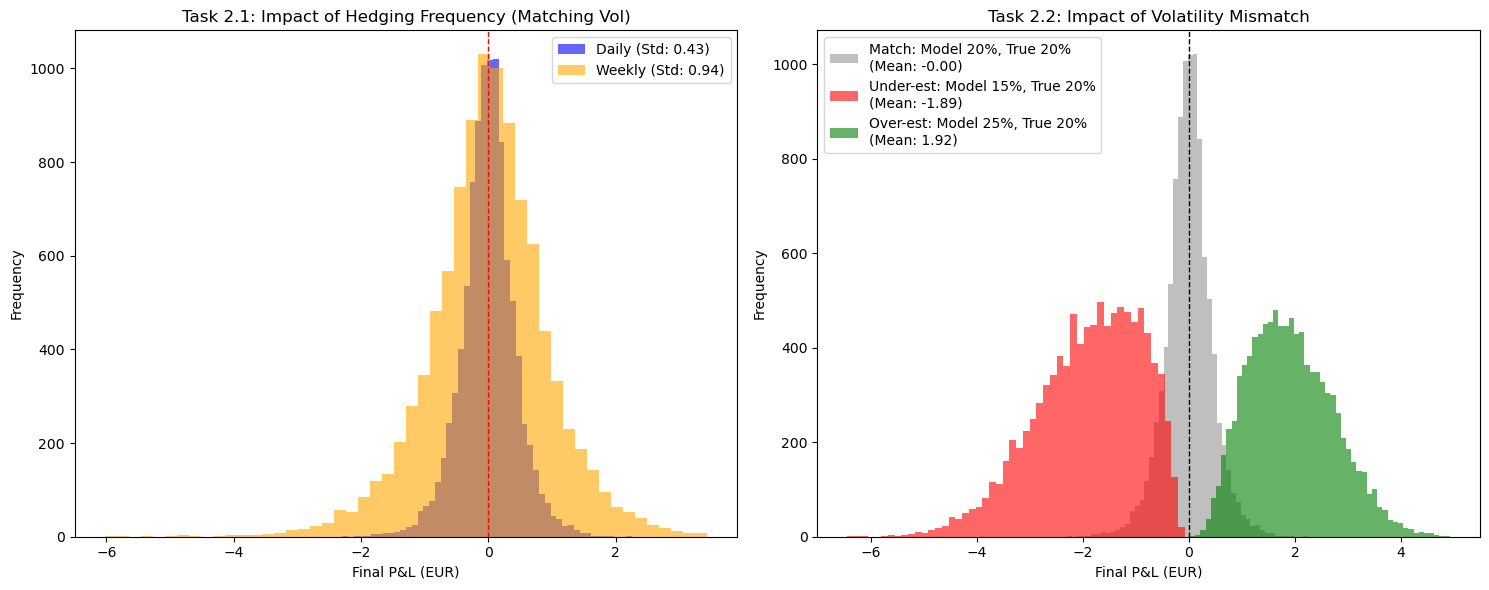

In [7]:
# ==========================================
# Plotting the Results
# ==========================================

# Create a figure with two subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# ------------------------------------------
# Plot 1: Task 2.1 - Hedging Frequency (Daily vs Weekly)
# ------------------------------------------
ax1 = axes[0]
# Plot daily hedging P&L
ax1.hist(pnl_daily, bins=50, alpha=0.6, label=f'Daily (Std: {np.std(pnl_daily):.2f})', color='blue')
# Plot weekly hedging P&L
ax1.hist(pnl_weekly, bins=50, alpha=0.6, label=f'Weekly (Std: {np.std(pnl_weekly):.2f})', color='orange')

ax1.set_title('Task 2.1: Impact of Hedging Frequency (Matching Vol)')
ax1.set_xlabel('Final P&L (EUR)')
ax1.set_ylabel('Frequency')
ax1.axvline(x=0, color='red', linestyle='--', linewidth=1) # Add a vertical line at P&L = 0
ax1.legend()

# ------------------------------------------
# Plot 2: Task 2.2 - Volatility Mismatch
# ------------------------------------------
ax2 = axes[1]
# Baseline: Matching Vol
ax2.hist(pnl_daily, bins=50, alpha=0.5, label=f'Match: Model 20%, True 20%\n(Mean: {np.mean(pnl_daily):.2f})', color='gray')
# Under-estimation
ax2.hist(pnl_under_est, bins=50, alpha=0.6, label=f'Under-est: Model 15%, True 20%\n(Mean: {np.mean(pnl_under_est):.2f})', color='red')
# Over-estimation
ax2.hist(pnl_over_est, bins=50, alpha=0.6, label=f'Over-est: Model 25%, True 20%\n(Mean: {np.mean(pnl_over_est):.2f})', color='green')

ax2.set_title('Task 2.2: Impact of Volatility Mismatch')
ax2.set_xlabel('Final P&L (EUR)')
ax2.set_ylabel('Frequency')
ax2.axvline(x=0, color='black', linestyle='--', linewidth=1) # Add a vertical line at P&L = 0
ax2.legend()

plt.tight_layout()
# plt.savefig('hedging_results.png') # You can uncomment this line to save the plot as a PNG file
plt.show()